In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_Li_27c_J3_nf4_v1.0.2.pth

In [14]:
!nvidia-smi --query-gpu=name --format=csv,noheader | head -n 1

NVIDIA GeForce RTX 4090


In [1]:
import io
import time
import torch
import numpy as np
import PIL
from torchvision.transforms import ToPILImage, PILToTensor
from datasets import load_dataset, Image
from walloc import walloc
from piq import LPIPS, DISTS, psnr, multi_scale_ssim

class Config: pass

In [2]:
checkpoint = torch.load("RGB_Li_27c_J3_nf4_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec.eval();

In [3]:
lpips_loss = LPIPS().to("cuda")
dists_loss = DISTS().to("cuda")

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
LSDIR = load_dataset("danjacobellis/LSDIR_val", split='validation')

In [5]:
def walloc_compress(sample):
    with torch.no_grad():
        img = sample['image']
        x = PILToTensor()(img).to(torch.float)
        x = (x/255 - 0.5).unsqueeze(0).to(device)
        H, W = x.size(2), x.size(3)
        x_padded = walloc.pad(x,p=16)

        t0 = time.time()
        X = codec.wavelet_analysis(x_padded,codec.J)
        Y = codec.encoder(X)
        webp = walloc.latent_to_pil(Y.to("cpu"),codec.latent_bits, 3)[0]
        buff = io.BytesIO()
        webp.save(buff, format='WEBP', lossless=True)
        webp_bytes = buff.getbuffer()
        encode_time = time.time() - t0

        t0 = time.time()
        Y = walloc.pil_to_latent([PIL.Image.open(buff)], codec.latent_dim, codec.latent_bits, 3).to(device)
        X_hat = codec.decoder(Y)
        x_hat = codec.wavelet_synthesis(X_hat,codec.J)
        x_hat = codec.clamp(x_hat)
        decode_time = time.time() - t0
        
        x_hat = walloc.crop(x_hat, (H,W))
        rec = ToPILImage()(x_hat[0] + 0.5)
        buff2 = io.BytesIO()
        rec.save(buff2, format='WEBP', lossless=True)
        rec_webp_bytes = buff2.getbuffer()

        bpp = 8*len(webp_bytes)/(H*W)
        PSNR = psnr(x+0.5,x_hat+0.5)
        MSSIM = multi_scale_ssim(x+0.5,x_hat+0.5)
        LPIPS_dB = -10*np.log10(lpips_loss(x.to("cuda")+0.5, x_hat.to("cuda")+0.5).item())
        DISTS_dB = -10*np.log10(dists_loss(x.to("cuda")+0.5, x_hat.to("cuda")+0.5).item())        
        
    return {
        'recovered': rec_webp_bytes,
        'compressed': webp_bytes,
        'encode_time': encode_time,
        'decode_time': decode_time,
        'bpp': bpp,
        'PSNR': PSNR,
        'MSSIM': MSSIM,
        'LPIPS_dB': LPIPS_dB,
        'DISTS_dB': DISTS_dB,
    }

In [6]:
device = "cuda"
codec = codec.to(device)
gpu = LSDIR.map(walloc_compress)
gpu = gpu.cast_column('recovered',Image())
gpu = gpu.cast_column('compressed',Image())

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [7]:
def walloc_compress_cpu(sample):
    with torch.no_grad():
        img = sample['image']
        x = PILToTensor()(img).to(torch.float)
        x = (x/255 - 0.5).unsqueeze(0).to(device)
        H, W = x.size(2), x.size(3)
        x_padded = walloc.pad(x,p=8)

        t0 = time.time()
        X = codec.wavelet_analysis(x_padded,codec.J)
        Y = codec.encoder(X)
        webp = walloc.latent_to_pil(Y.to("cpu"),codec.latent_bits, 3)[0]
        buff = io.BytesIO()
        webp.save(buff, format='WEBP', lossless=True)
        webp_bytes = buff.getbuffer()
        encode_time = time.time() - t0

        t0 = time.time()
        Y = walloc.pil_to_latent([PIL.Image.open(buff)], codec.latent_dim, codec.latent_bits, 3).to(device)
        X_hat = codec.decoder(Y)
        x_hat = codec.wavelet_synthesis(X_hat,codec.J)
        x_hat = codec.clamp(x_hat)
        decode_time = time.time() - t0
                
    return {
        'cpu_encode_time': encode_time,
        'cpu_decode_time': decode_time,
    }

In [8]:
device = "cpu"
codec = codec.to(device)
cpu = LSDIR.map(walloc_compress_cpu)
combined = gpu.add_column('cpu_encode_time',cpu['cpu_encode_time'])
combined = combined.add_column('cpu_decode_time',cpu['cpu_decode_time'])

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [9]:
metrics = [
     'encode_time',
     'decode_time',
     'bpp',
     'PSNR',
     'MSSIM',
     'LPIPS_dB',
     'DISTS_dB', 
     'cpu_encode_time',
     'cpu_decode_time',
]

In [10]:
for metric in metrics:
    μ = np.mean(combined[metric])
    print(f"{metric}: {μ}")

encode_time: 0.039495126724243164
decode_time: 0.008253249168395996
bpp: 1.1535727238679194
PSNR: 29.678887504577638
MSSIM: 0.9778808712959289
LPIPS_dB: 7.667304311633589
DISTS_dB: 15.017913750143787
cpu_encode_time: 0.0627421236038208
cpu_decode_time: 1.5730030298233033


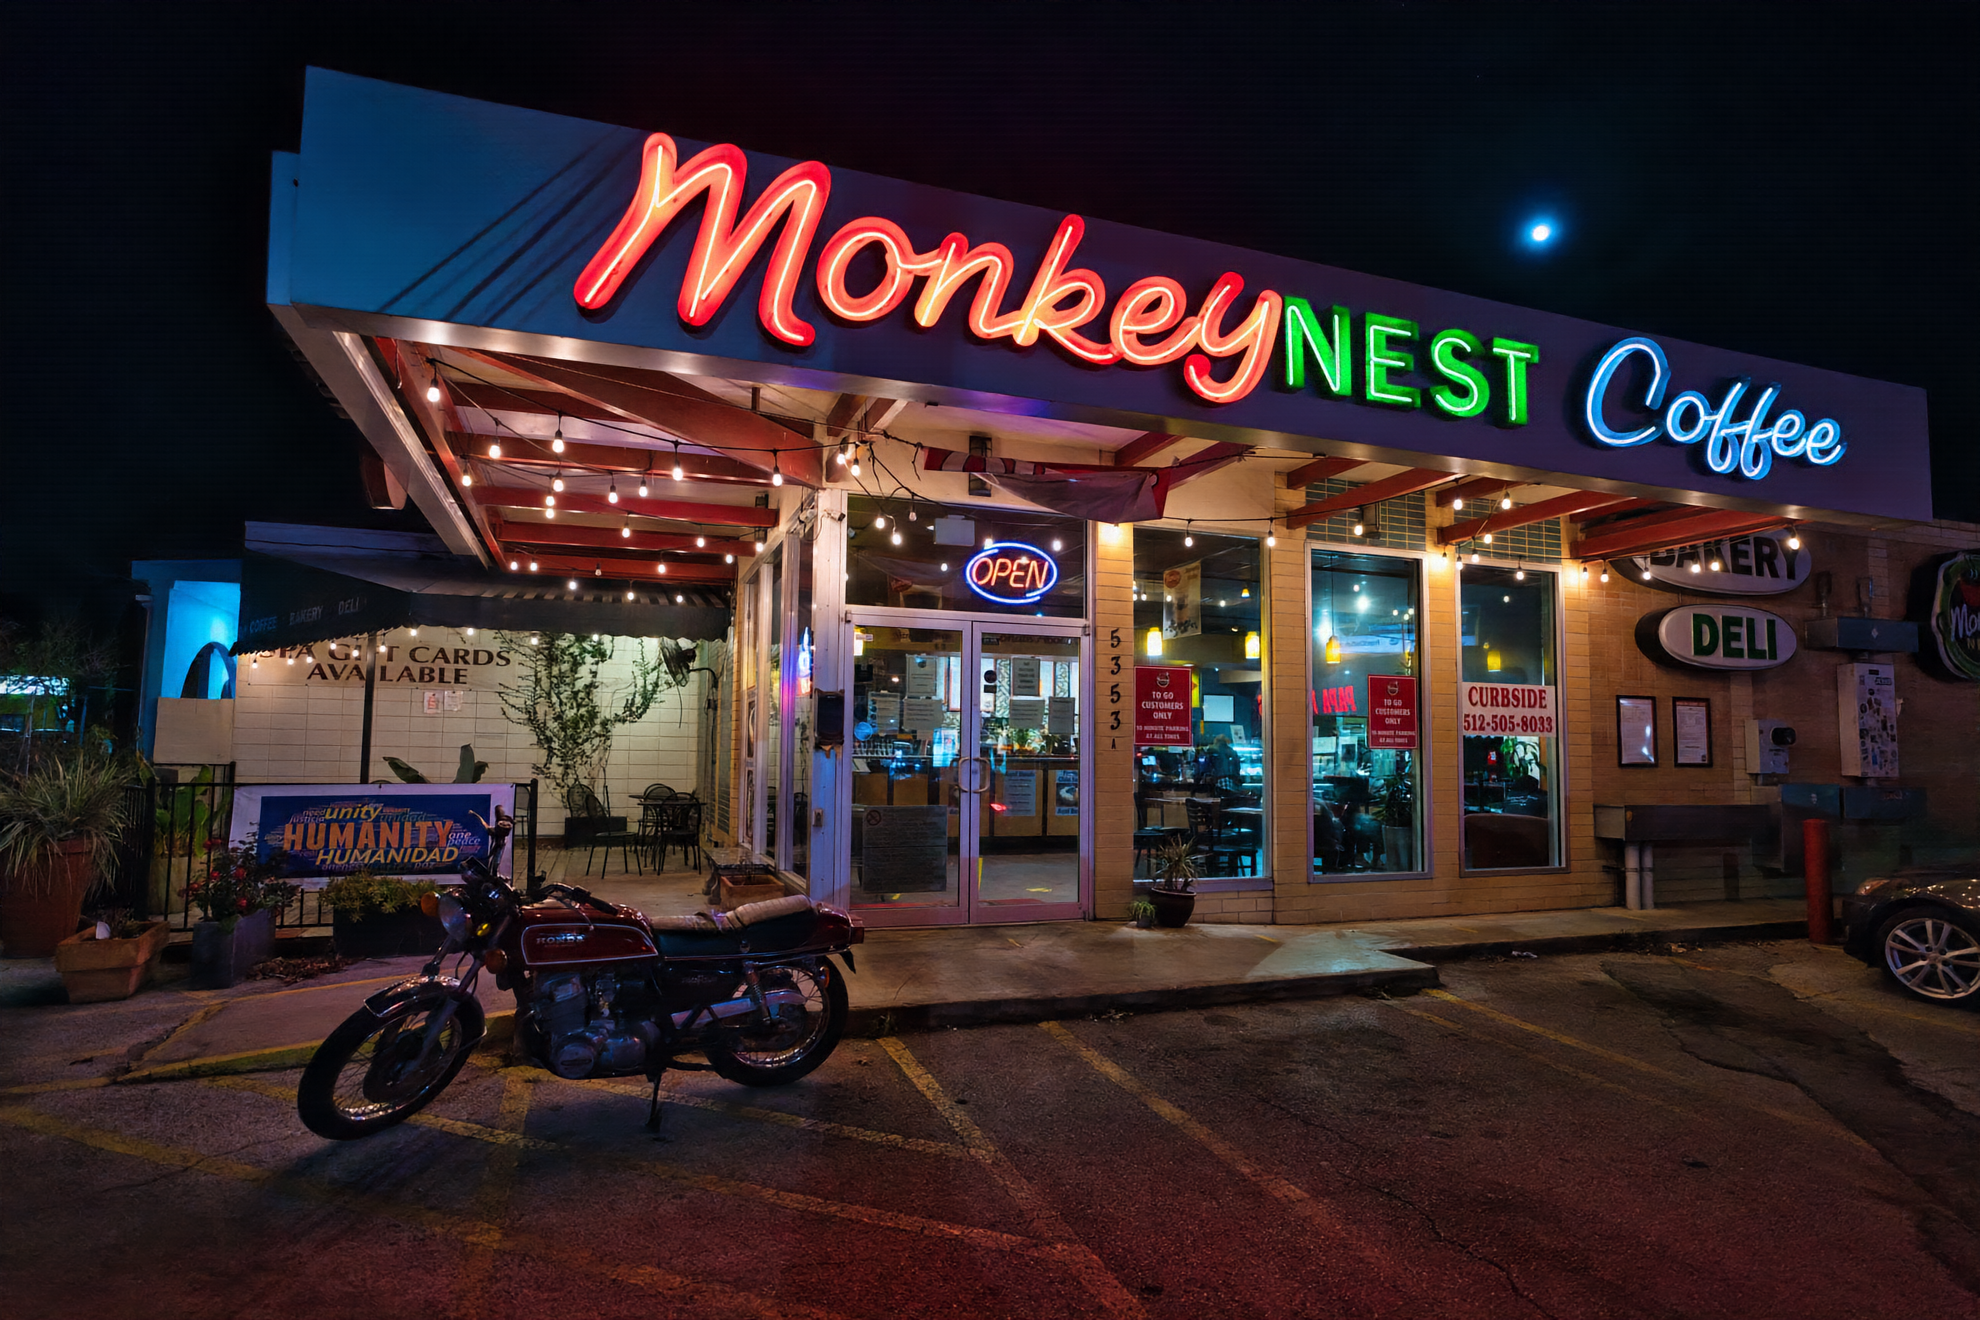

In [11]:
combined[28]['recovered']

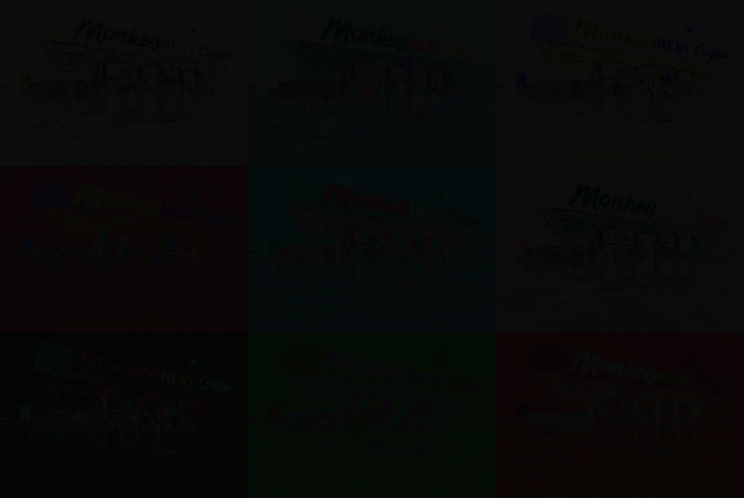

In [12]:
combined[28]['compressed']